In [1]:
from keras import backend as K
cfg = K.tf.ConfigProto()
cfg.gpu_options.allow_growth = True
K.set_session(K.tf.Session(config=cfg))


Using TensorFlow backend.


In [54]:
import numpy as np
from scipy.misc import imresize
import pickle
import imageio

# Dependencies for Model
import keras
from keras.layers import Conv2DTranspose, Conv2D, MaxPooling2D, concatenate
from keras.models import Model

from keras.layers import Input, Dense
from keras.models import Model
from keras.layers import Activation, Dense, BatchNormalization, Reshape
from keras import losses, optimizers
import tensorflow as tf

import matplotlib.pyplot as plt

import keras.backend as K

from skimage.measure import label

from keras.preprocessing import image
from tensorflow import set_random_seed
import pandas as pd

import numpy as np
import matplotlib.pyplot as plt
from scipy import ndimage as ndi

from skimage.morphology import watershed
from skimage.feature import peak_local_max


In [55]:
sess = tf.Session()
K.set_session(sess)

set_random_seed(0)

In [56]:
DATA_SPLIT = 650
IMAGE_MEAN = 0.17166166804067506

In [189]:
images = pickle.load(open('../baseline_data/train_X_baseline.p', 'rb'))
labels = pickle.load(open('../baseline_data/train_Y_baseline.p', 'rb'))

In [190]:
labels = np.expand_dims(labels, axis=-1)

In [191]:
train_X = images[:DATA_SPLIT,:,:,:] - IMAGE_MEAN
train_Y = labels[:DATA_SPLIT,:,:,:] #Reduced range to [0,1]

valid_X = images[DATA_SPLIT:,:,:,:] - IMAGE_MEAN
valid_Y = labels[DATA_SPLIT:,:,:,:] #Reduced range to [0,1]

In [192]:
print(np.max(valid_Y))

1.0


## U-Net

In [193]:
# Custom Loss Funciton

smooth = 1

def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth) 


def dice_coef_loss(y_true, y_pred):
    return -dice_coef(y_true, y_pred)


In [194]:
def weighted_binary_crossentropy_loss(y_true, y_pred):
    dice = -dice_coef(y_true, y_pred)
    return dice
  
def weighted_dice_coef(y_true, y_pred):
    return dice_coef(y_true[:,:,:,0], y_pred[:,:,:,0])
  
def mean_iou(y_true, y_pred):
    prec = []
    for t in np.arange(0.5, 1.0, 0.05):
        y_pred_ = tf.to_int32(y_pred > t)
        score, up_opt = tf.metrics.mean_iou(y_true, y_pred_, 2)
        K.get_session().run(tf.local_variables_initializer())
        with tf.control_dependencies([up_opt]):
            score = tf.identity(score)
        prec.append(score)
    return K.mean(K.stack(prec), axis=0)


In [195]:
# U-Net

inputs = Input((256, 256, 3))
conv1 = Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
conv1 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv1)
pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

conv2 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool1)
conv2 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv2)
pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

conv3 = Conv2D(256, (3, 3), activation='relu', padding='same')(pool2)
conv3 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv3)
pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

conv4 = Conv2D(512, (3, 3), activation='relu', padding='same')(pool3)
conv4 = Conv2D(512, (3, 3), activation='relu', padding='same')(conv4)
pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(pool4)
conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(conv5)

up6 = concatenate([Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(conv5), conv4], axis=3)
conv6 = Conv2D(512, (3, 3), activation='relu', padding='same')(up6)
conv6 = Conv2D(512, (3, 3), activation='relu', padding='same')(conv6)

up7 = concatenate([Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(conv6), conv3], axis=3)
conv7 = Conv2D(256, (3, 3), activation='relu', padding='same')(up7)
conv7 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv7)

up8 = concatenate([Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conv7), conv2], axis=3)
conv8 = Conv2D(128, (3, 3), activation='relu', padding='same')(up8)
conv8 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv8)

up9 = concatenate([Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(conv8), conv1], axis=3)
conv9 = Conv2D(64, (3, 3), activation='relu', padding='same')(up9)
conv9 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv9)

conv10 = Conv2D(1, (1, 1), activation='sigmoid')(conv9)

model = Model(inputs=[inputs], outputs=[conv10])

model.compile(optimizer='adam', loss=weighted_binary_crossentropy_loss, metrics=[mean_iou]) 

In [196]:
model.fit([train_X], [train_Y], batch_size = 32, epochs = 400, validation_data=(valid_X, valid_Y))

# model.fit_generator(zip(x,y), 
#                     validation_data=zip(x_val, y_val), 
#                     validation_steps=1, 
#                     steps_per_epoch=len(train_X)/32,
#                     epochs=50)

Train on 650 samples, validate on 20 samples
Epoch 1/400
650/650 [==============================] - 21s 32ms/step - loss: -0.3258 - mean_iou: 0.4392 - val_loss: -0.4206 - val_mean_iou: 0.4944
Epoch 2/400
650/650 [==============================] - 14s 22ms/step - loss: -0.5166 - mean_iou: 0.5076 - val_loss: -0.5359 - val_mean_iou: 0.5238
Epoch 3/400
650/650 [==============================] - 14s 22ms/step - loss: -0.5412 - mean_iou: 0.5245 - val_loss: -0.4939 - val_mean_iou: 0.5330
Epoch 4/400
650/650 [==============================] - 14s 22ms/step - loss: -0.6913 - mean_iou: 0.5487 - val_loss: -0.6689 - val_mean_iou: 0.5667
Epoch 5/400
650/650 [==============================] - 14s 22ms/step - loss: -0.7445 - mean_iou: 0.5818 - val_loss: -0.6549 - val_mean_iou: 0.5959
Epoch 6/400
650/650 [==============================] - 14s 22ms/step - loss: -0.7500 - mean_iou: 0.6066 - val_loss: -0.7093 - val_mean_iou: 0.6170
Epoch 7/400
650/650 [==============================] - 14s 22ms/step - lo

650/650 [==============================] - 14s 22ms/step - loss: -0.9273 - mean_iou: 0.8512 - val_loss: -0.8955 - val_mean_iou: 0.8515
Epoch 112/400
650/650 [==============================] - 14s 22ms/step - loss: -0.9286 - mean_iou: 0.8517 - val_loss: -0.8957 - val_mean_iou: 0.8520
Epoch 113/400
650/650 [==============================] - 14s 22ms/step - loss: -0.9291 - mean_iou: 0.8523 - val_loss: -0.8922 - val_mean_iou: 0.8525
Epoch 114/400
650/650 [==============================] - 14s 21ms/step - loss: -0.9300 - mean_iou: 0.8528 - val_loss: -0.8910 - val_mean_iou: 0.8531
Epoch 115/400
650/650 [==============================] - 14s 22ms/step - loss: -0.9297 - mean_iou: 0.8533 - val_loss: -0.8882 - val_mean_iou: 0.8536
Epoch 116/400
650/650 [==============================] - 14s 22ms/step - loss: -0.9297 - mean_iou: 0.8538 - val_loss: -0.8932 - val_mean_iou: 0.8541
Epoch 117/400
650/650 [==============================] - 14s 22ms/step - loss: -0.9300 - mean_iou: 0.8543 - val_loss: -0

650/650 [==============================] - 14s 22ms/step - loss: -0.9457 - mean_iou: 0.8746 - val_loss: -0.8868 - val_mean_iou: 0.8747
Epoch 167/400
650/650 [==============================] - 14s 22ms/step - loss: -0.9479 - mean_iou: 0.8749 - val_loss: -0.8865 - val_mean_iou: 0.8751
Epoch 168/400
650/650 [==============================] - 14s 22ms/step - loss: -0.9500 - mean_iou: 0.8752 - val_loss: -0.8861 - val_mean_iou: 0.8754
Epoch 169/400
650/650 [==============================] - 14s 22ms/step - loss: -0.9520 - mean_iou: 0.8756 - val_loss: -0.8899 - val_mean_iou: 0.8758
Epoch 170/400
650/650 [==============================] - 14s 22ms/step - loss: -0.9527 - mean_iou: 0.8759 - val_loss: -0.8836 - val_mean_iou: 0.8761
Epoch 171/400
650/650 [==============================] - 14s 22ms/step - loss: -0.9540 - mean_iou: 0.8763 - val_loss: -0.8868 - val_mean_iou: 0.8765
Epoch 172/400
650/650 [==============================] - 14s 22ms/step - loss: -0.9539 - mean_iou: 0.8766 - val_loss: -0

650/650 [==============================] - 14s 21ms/step - loss: -0.9640 - mean_iou: 0.8909 - val_loss: -0.8877 - val_mean_iou: 0.8911
Epoch 222/400
650/650 [==============================] - 14s 22ms/step - loss: -0.9645 - mean_iou: 0.8912 - val_loss: -0.8859 - val_mean_iou: 0.8913
Epoch 223/400
650/650 [==============================] - 14s 22ms/step - loss: -0.9638 - mean_iou: 0.8914 - val_loss: -0.8868 - val_mean_iou: 0.8916
Epoch 224/400
650/650 [==============================] - 14s 21ms/step - loss: -0.9631 - mean_iou: 0.8917 - val_loss: -0.8863 - val_mean_iou: 0.8918
Epoch 225/400
650/650 [==============================] - 14s 22ms/step - loss: -0.9634 - mean_iou: 0.8919 - val_loss: -0.8878 - val_mean_iou: 0.8920
Epoch 226/400
650/650 [==============================] - 14s 22ms/step - loss: -0.9645 - mean_iou: 0.8922 - val_loss: -0.8879 - val_mean_iou: 0.8923
Epoch 227/400
650/650 [==============================] - 14s 22ms/step - loss: -0.9628 - mean_iou: 0.8924 - val_loss: -0

650/650 [==============================] - 14s 22ms/step - loss: -0.9686 - mean_iou: 0.9025 - val_loss: -0.8848 - val_mean_iou: 0.9025
Epoch 277/400
650/650 [==============================] - 14s 22ms/step - loss: -0.9690 - mean_iou: 0.9026 - val_loss: -0.8886 - val_mean_iou: 0.9027
Epoch 278/400
650/650 [==============================] - 14s 22ms/step - loss: -0.9688 - mean_iou: 0.9028 - val_loss: -0.8822 - val_mean_iou: 0.9029
Epoch 279/400
650/650 [==============================] - 14s 22ms/step - loss: -0.9679 - mean_iou: 0.9030 - val_loss: -0.8857 - val_mean_iou: 0.9031
Epoch 280/400
650/650 [==============================] - 14s 22ms/step - loss: -0.9684 - mean_iou: 0.9032 - val_loss: -0.8878 - val_mean_iou: 0.9032
Epoch 281/400
650/650 [==============================] - 14s 22ms/step - loss: -0.9685 - mean_iou: 0.9033 - val_loss: -0.8862 - val_mean_iou: 0.9034
Epoch 282/400
650/650 [==============================] - 14s 22ms/step - loss: -0.9682 - mean_iou: 0.9035 - val_loss: -0

650/650 [==============================] - 14s 21ms/step - loss: -0.9710 - mean_iou: 0.9107 - val_loss: -0.8893 - val_mean_iou: 0.9108
Epoch 332/400
650/650 [==============================] - 14s 21ms/step - loss: -0.9711 - mean_iou: 0.9108 - val_loss: -0.8864 - val_mean_iou: 0.9109
Epoch 333/400
650/650 [==============================] - 14s 22ms/step - loss: -0.9711 - mean_iou: 0.9110 - val_loss: -0.8850 - val_mean_iou: 0.9110
Epoch 334/400
650/650 [==============================] - 14s 22ms/step - loss: -0.9708 - mean_iou: 0.9111 - val_loss: -0.8842 - val_mean_iou: 0.9111
Epoch 335/400
650/650 [==============================] - 14s 21ms/step - loss: -0.9698 - mean_iou: 0.9112 - val_loss: -0.8870 - val_mean_iou: 0.9113
Epoch 336/400
650/650 [==============================] - 14s 21ms/step - loss: -0.9712 - mean_iou: 0.9113 - val_loss: -0.8880 - val_mean_iou: 0.9114
Epoch 337/400
650/650 [==============================] - 14s 21ms/step - loss: -0.9717 - mean_iou: 0.9115 - val_loss: -0

650/650 [==============================] - 14s 21ms/step - loss: -0.9729 - mean_iou: 0.9170 - val_loss: -0.8839 - val_mean_iou: 0.9171
Epoch 387/400
650/650 [==============================] - 14s 22ms/step - loss: -0.9728 - mean_iou: 0.9171 - val_loss: -0.8869 - val_mean_iou: 0.9172
Epoch 388/400
650/650 [==============================] - 14s 22ms/step - loss: -0.9716 - mean_iou: 0.9172 - val_loss: -0.8850 - val_mean_iou: 0.9172
Epoch 389/400
650/650 [==============================] - 14s 21ms/step - loss: -0.9726 - mean_iou: 0.9173 - val_loss: -0.8859 - val_mean_iou: 0.9173
Epoch 390/400
650/650 [==============================] - 14s 21ms/step - loss: -0.9731 - mean_iou: 0.9174 - val_loss: -0.8876 - val_mean_iou: 0.9174
Epoch 391/400
650/650 [==============================] - 14s 21ms/step - loss: -0.9730 - mean_iou: 0.9175 - val_loss: -0.8847 - val_mean_iou: 0.9175
Epoch 392/400
650/650 [==============================] - 14s 21ms/step - loss: -0.9730 - mean_iou: 0.9176 - val_loss: -0

## Predict with Model

In [225]:
  # Predict Validation Data
pred = model.predict(valid_X)
print(np.mean(pred))

0.1635146


1.0

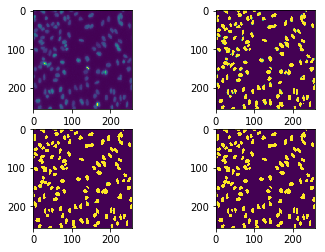

In [198]:
sample = 7

fig, ax = plt.subplots(nrows=2,ncols=2)

pred_rounded = np.where(pred[sample,:,:,0] > 0.99, 1, 0)
ax[0,0].imshow(valid_X[sample,:,:,0])
ax[0,1].imshow(valid_Y[sample,:,:,0])
ax[1,0].imshow(pred[sample,:,:,0])
ax[1,1].imshow(pred_rounded)
np.amax(pred[sample,:,:,0])
# pred[sample,:,:,0]


In [199]:
def iou_metric(y_true_in, y_pred_in, print_table=False):
    labels = label(y_true_in > 0.5)
    y_pred = label(y_pred_in > 0.55)
    
    true_objects = len(np.unique(labels))
    pred_objects = len(np.unique(y_pred))

    intersection = np.histogram2d(labels.flatten(), y_pred.flatten(), bins=(true_objects, pred_objects))[0]

    # Compute areas (needed for finding the union between all objects)
    area_true = np.histogram(labels, bins = true_objects)[0]
    area_pred = np.histogram(y_pred, bins = pred_objects)[0]
    area_true = np.expand_dims(area_true, -1)
    area_pred = np.expand_dims(area_pred, 0)

    # Compute union
    union = area_true + area_pred - intersection

    # Exclude background from the analysis
    intersection = intersection[1:,1:]
    union = union[1:,1:]
    union[union == 0] = 1e-9

    # Compute the intersection over union
    iou = intersection / union

    # Precision helper function
    def precision_at(threshold, iou):
        matches = iou > threshold
        true_positives = np.sum(matches, axis=1) == 1   # Correct objects
        false_positives = np.sum(matches, axis=0) == 0  # Missed objects
        false_negatives = np.sum(matches, axis=1) == 0  # Extra objects
        tp, fp, fn = np.sum(true_positives), np.sum(false_positives), np.sum(false_negatives)
        return tp, fp, fn

    # Loop over IoU thresholds
    prec = []
    if print_table:
        print("Thresh\tTP\tFP\tFN\tPrec.")
    for t in np.arange(0.5, 1.0, 0.05):
        tp, fp, fn = precision_at(t, iou)
        if (tp + fp + fn) > 0:
            p = tp / (tp + fp + fn)
        else:
            p = 0
        if print_table:
            print("{:1.3f}\t{}\t{}\t{}\t{:1.3f}".format(t, tp, fp, fn, p))
        prec.append(p)
    
    if print_table:
        print("AP\t-\t-\t-\t{:1.3f}".format(np.mean(prec)))
    return np.mean(prec)

def iou_metric_batch(y_true_in, y_pred_in):
    batch_size = len(y_true_in)
    metric = []
    for batch in range(batch_size):
        value = iou_metric(y_true_in[batch], y_pred_in[batch])
        metric.append(value)
#     return np.array(np.mean(metric), dtype=np.float32)
    return metric

In [200]:
iou_metric(valid_Y[:,:,:,0], pred[:,:,:,0])

0.4069284438691413

In [250]:
def apply_watershed(pred):
    watershed_pred = []
    for i in range(len(pred)):
        image = pred[i,:,:,0] > 0.55
        
        
        distance = ndi.distance_transform_edt(image)
        local_maxi = peak_local_max(distance, indices=False, footprint=np.ones((2, 2)),
                            labels=image)
        markers = ndi.label(local_maxi)[0]
        labels = watershed(-distance, markers, mask=image)
       
        watershed_pred.append(labels)
        
    watershed_pred = np.stack(watershed_pred, axis=0)
    return watershed_pred

watershed_pred = apply_watershed(pred)

In [251]:
iou_metric(valid_Y[:,:,:,0], watershed_pred)

0.40792463931850315

In [252]:
print(np.amax(np.where(watershed_pred[0] >= 1, 1 ,0)))

1


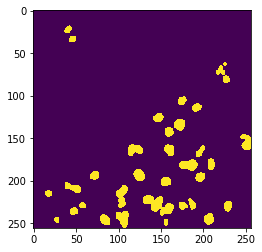

In [253]:
plt.imshow(valid_Y[2,:,:,0])

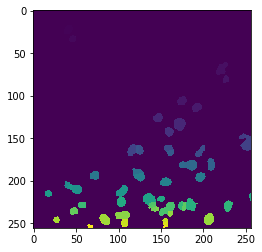

In [254]:
plt.imshow(watershed_pred[2])

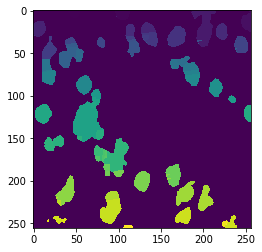

In [255]:
plt.imshow(watershed_pred[0] - np.where(pred[0,:,:,0] > 0.55, 1,0))

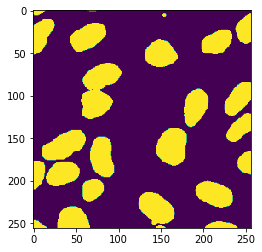

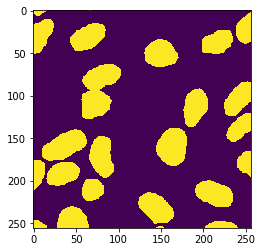

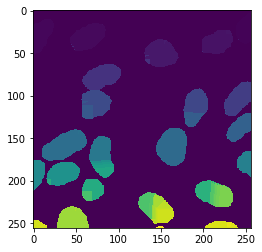

In [209]:
plt.imshow(valid_Y[1,:,:,0])
plt.figure()
plt.imshow(np.where(pred[1,:,:,0] > 0.55, 1,0))
plt.figure()
plt.imshow(watershed_pred[1])

## Methods for Saving/Loading Trained Model

### Save Model

In [210]:
#SAVE MODEL

model.save('../model_weights/unet_blah.h5')

### Load Model

In [67]:

from keras.models import load_model
# model = load_model('unet_baseline.h5', custom_objects={'weighted_binary_crossentropy_loss': weighted_binary_crossentropy_loss, 'mean_iou': mean_iou})
model = load_model('../model_weights/unet_baseline.h5', custom_objects={'mean_iou': mean_iou})



# Use Test Data

In [257]:
test_images = pickle.load(open('../test_images.p', 'rb'))
##test_images2 = pickle.load(open('test_X_baseline2.p', 'rb'))

##test_images = np.concatenate([test_images1, test_images2], axis=0) 

test_sizes = pickle.load(open('../test_sizes.p', 'rb'))
test_ids = pickle.load(open('../test_img_names.p', 'rb'))

In [258]:
model

In [259]:
test_images = test_images - IMAGE_MEAN
pred = model.predict(test_images)
watershed_pred = apply_watershed(pred)

In [260]:
preds = []
for i in range(len(test_sizes)):
    preds.append(imresize(watershed_pred[i],test_sizes[i][:2]))

/home/kenkang/anaconda3/envs/deeplearning/lib/python3.6/site-packages/ipykernel/__main__.py:3: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  app.launch_new_instance()


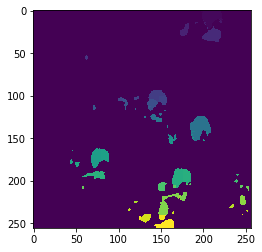

In [261]:
plt.imshow(preds[0][:,:])

In [262]:
import pandas as pd

In [263]:

import re


def regex(txt):

  re1 = '(?:[a-z0-9][a-z]*[0-9]+[a-z0-9]*)/'

  rg = re.compile(re1)
  m = rg.search(txt)
  if m:
      alphanum1=m.group(0)
  return alphanum1[0:-1]


/home/kenkang/anaconda3/envs/deeplearning/lib/python3.6/site-packages/ipykernel/__main__.py:4: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(256, 256, 3)
(414, 278)


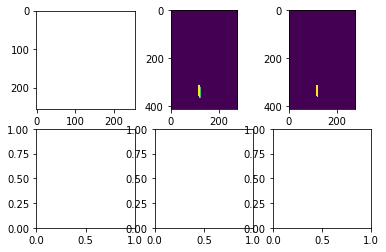

In [264]:
sample = 2
shape = test_sizes[sample]
shape = (shape[0],shape[1])
mask = imresize(pred[sample,:,:,0], shape) / 255
mask2 = label(np.where(mask > 0.9, 1, 0),connectivity=2)



fig, ax = plt.subplots(nrows=2,ncols=3)

ax[0,0].imshow(test_images[sample])
ax[0,1].imshow(mask)
ax[0,2].imshow(mask2)

print(test_images[sample].shape)
print(mask.shape)

In [265]:
#Separate Masks
from scipy import ndimage
labels, nlabels = ndimage.label(watershed[0])

label_arrays = []
for label_num in range(1, nlabels+1):
    label_mask = np.where(labels == label_num, 1, 0)
    label_arrays.append(label_mask)

print('There are {} separate components / objects detected.'.format(nlabels))

TypeError: 'function' object is not subscriptable

In [266]:
def rle_encoding(x):
    '''
    x: numpy array of shape (height, width), 1 - mask, 0 - background
    Returns run length as list
    '''
    dots = np.where(x.T.flatten()==1)[0] # .T sets Fortran order down-then-right
    run_lengths = []
    prev = -2
    for b in dots:
        if (b>prev+1): run_lengths.extend((b+1, 0))
        run_lengths[-1] += 1
        prev = b
    return run_lengths

def prob_to_rles(x, cut_off = 0.5):
    lab_img = label(x>cut_off)
    if lab_img.max()<1:
        lab_img[0,0] = 1 # ensure at least one prediction per image
    for i in range(1, lab_img.max()+1):
        yield rle_encoding(lab_img==i)

In [267]:
new_test_ids = []
rles = []
count = 0
for n, id_ in enumerate(test_ids):
    rle = list(prob_to_rles(preds[n]))
    
    rles.extend(rle)
    new_test_ids.extend([id_[:-4] for i in range(len(rle))])

In [268]:

# Create submission DataFrame
sub = pd.DataFrame()
sub['ImageId'] = new_test_ids
sub['EncodedPixels'] = pd.Series(rles).apply(lambda x: ' '.join(str(y) for y in x))
sub[['ImageId', 'EncodedPixels']].to_csv('baseline_submission.csv', index=False)

In [269]:
sample = pd.read_csv("stage2_sample_submission_final.csv")

In [270]:
solution = sorted(zip(new_test_ids, rles))
new_test_ids = []
rles = []
for x,y in solution:
    new_test_ids.append(x)

    rles.append(y)

In [271]:
sub = pd.DataFrame()
sub['ImageId'] = new_test_ids
sub['EncodedPixels'] = pd.Series(rles).apply(lambda x: ' '.join(str(y) for y in x))
sub.to_csv('baseline_submission.csv', index=False)

In [272]:
len(sub.ImageId.unique())

3019